# Research Engineer test task

#### Выполнила Шарыпина Даша

Я тренировала `resnet18` с использованием pretrained weights, так как из gpu только ноутбук.

Для увеличения accuracy я использовала аугментации данных из библиотеки `albumentations`. Например: горизонтальное отражение изображения, изменение контрастности и контрастности, а так же изменение гамма-значения.

В качестве оптимизатора использован `SGD` с `learning rate = 1e-3` и `momentum = 0.9`. Еще я пробовала использовать `Adam` c `learning rate = 1e-4`, но это не дало улучшения результатов: `test accuracy = 57%` за 4 эпохи. Также лучший результат получился, когда я добавила `learning rate scheduler`, который умножает learning rate на 0.1 каждые 7 эпох.

В результате я получила модель с `test accuracy = 56%`

In [6]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

import cv2

# Dataset


In [7]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [8]:
ROOT = Path("/home/dasha/test-task-master")
DATA_ROOT = ROOT / "data/tiny-imagenet-200"
RESULTS_ROOT = ROOT / "results/"
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "pretrained_sgd"
CKPT_NAME = "pretrained_sgd_model.pth"
DEVICE = torch.device("cuda")

In [4]:
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [5]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    _df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self._df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self._df.loc[index, :]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self._transform:
            image = self._transform(image=image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self._df)

# Training loop

Добавлены аугментации данных с помощью библиотеки albumentations

In [6]:
BATCH_SIZE = 128

from albumentations import Compose, RandomContrast, RandomGamma, RandomBrightness, OneOf, Normalize, HorizontalFlip
from albumentations.pytorch import ToTensor


transform = Compose([
   HorizontalFlip(p=0.5),
   OneOf(
            [
                RandomContrast(),
                RandomGamma(),
                RandomBrightness(),
            ],
            p = 0.5
        ),
   Normalize(
        mean=[0.4802, 0.4481, 0.3975],
        std=[0.2302, 0.2265, 0.2262]),
   ToTensor()
])

train_dataset = TinyImagenetDataset(DATA_ROOT / "train", transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)

test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)


In [8]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images['image'].to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images['image'].to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [9]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 200)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

loss_function = loss.CrossEntropyLoss()

Добавлен learning rate scheduler:

In [11]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

EPOCHS = 10
for epoch in range(EPOCHS):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
    
    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    scheduler.step()
    
    writer.close()


Train Epoch: 0 [ (26%)]	Loss: 3.120213




Test set: Average loss: 0.0197, Accuracy: 4184/10000 (42%)




Train Epoch: 1 [ (47%)]	Loss: 1.796226




Test set: Average loss: 0.0166, Accuracy: 4911/10000 (49%)




Train Epoch: 2 [ (54%)]	Loss: 1.496008




Test set: Average loss: 0.0154, Accuracy: 5150/10000 (52%)




Train Epoch: 3 [ (58%)]	Loss: 2.291593




Test set: Average loss: 0.0148, Accuracy: 5331/10000 (53%)




Train Epoch: 4 [ (62%)]	Loss: 1.482135




Test set: Average loss: 0.0144, Accuracy: 5497/10000 (55%)




Train Epoch: 5 [ (65%)]	Loss: 1.093214




Test set: Average loss: 0.0142, Accuracy: 5525/10000 (55%)




Train Epoch: 6 [ (68%)]	Loss: 1.828206




Test set: Average loss: 0.0144, Accuracy: 5547/10000 (55%)




Train Epoch: 7 [ (73%)]	Loss: 1.187251




Test set: Average loss: 0.0139, Accuracy: 5588/10000 (56%)




Train Epoch: 8 [ (74%)]	Loss: 1.695534




Test set: Average loss: 0.0140, Accuracy: 5614/10000 (56%)




Train Epoch: 9 [ (74%)]	Loss: 1.140002




Test set: Average loss: 0.0141, Accuracy: 5617/10000 (56%)



Adam lr = 1e-4, epoch = 4, test acc = 57%

# Visualisation

In [2]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Loss plots

In [12]:
train_loss = pd.read_csv(RESULTS_ROOT / 'pretrained_sgd/train_loss_plot.csv')
test_loss = pd.read_csv(RESULTS_ROOT / 'pretrained_sgd/test_loss_plot.csv')

__Train loss__

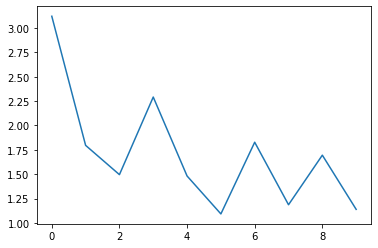

In [19]:
plt.plot(train_loss['Value'])

__Test loss__

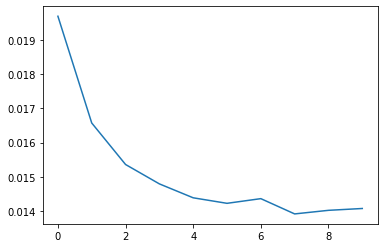

In [20]:
plt.plot(test_loss['Value'])

### Accuracy plots

In [13]:
train_accuracy = pd.read_csv(RESULTS_ROOT / 'pretrained_sgd/train_accuracy_plot.csv')
test_accuracy = pd.read_csv(RESULTS_ROOT / 'pretrained_sgd/test_accuracy_plot.csv')

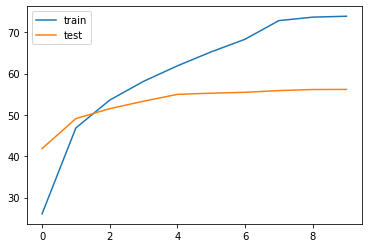

In [27]:
plt.plot(train_accuracy['Value'])
plt.plot(test_accuracy['Value'])
plt.legend(['train', 'test'])

### Confusion matrix

In [13]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images['image'].to(DEVICE), item.labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

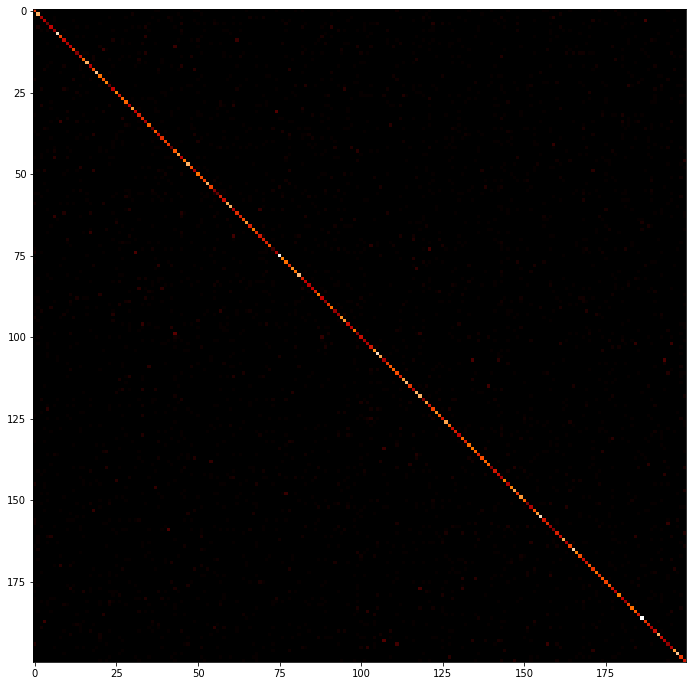

In [14]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()